In [1]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Admin\AppData\Local\Temp\ipykernel_9256\3061855017.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
review_data= pd.read_csv("Dataset\Reviews.csv")
review_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

568454
Unique Products
74258
Unique Users
256059


In [4]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [5]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))



#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
Score
5    363102
4     80654
1     52264
3     42638
2     29743
Name: count, dtype: int64
568401
-------------------------
No of Short reviews
373279


***
Let us pre-process the data
***

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)



In [9]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
      output = []
      for sent in texts:
            doc = nlp(sent) 
            output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
      return output

In [10]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

used fairly decent flavored coffee last batch bought tasted like someone dumped half cheap vanilla extract half artificial sweetener five phone calls tassimo customer service worst world phone call kraft customer service tassimos parent corporation phone call gevalia customer service failed produce explanation thank goodness bought krapp amazon email amazon produced refund would never swill hazelnut fact would bought tassimo machine actually pretty good known customer disservice
['decent', 'coffee', 'last', 'batch', 'cheap', 'vanilla', 'artificial', 'sweetener', 'phone', 'tassimo', 'customer', 'service', 'bad', 'world', 'phone', 'call', 'kraft', 'customer', 'service', 'parent', 'corporation', 'phone', 'call', 'customer', 'service', 'explanation', 'thank', 'amazon', 'refund', 'fact', 'tassimo', 'machine', 'good', 'customer', 'disservice']


***
Create vocabulary dictionary and document term matrix
***

In [11]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [12]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [13]:
lda_model.print_topics()

[(0,
  '0.023*"flavor" + 0.022*"product" + 0.021*"taste" + 0.020*"good" + 0.016*"honey" + 0.012*"perfect" + 0.012*"hair" + 0.011*"stuff" + 0.010*"cherry" + 0.010*"salad"'),
 (1,
  '0.052*"bag" + 0.018*"month" + 0.017*"year" + 0.017*"time" + 0.015*"seed" + 0.011*"date" + 0.011*"wellness" + 0.011*"chew" + 0.011*"last" + 0.010*"home"'),
 (2,
  '0.040*"flavor" + 0.037*"chocolate" + 0.037*"good" + 0.030*"snack" + 0.028*"chip" + 0.026*"great" + 0.024*"cookie" + 0.022*"taste" + 0.019*"salt" + 0.018*"sauce"'),
 (3,
  '0.057*"price" + 0.053*"store" + 0.038*"great" + 0.036*"good" + 0.033*"amazon" + 0.023*"local" + 0.021*"product" + 0.019*"grocery" + 0.014*"small" + 0.014*"size"'),
 (4,
  '0.071*"butter" + 0.063*"peanut" + 0.052*"blend" + 0.019*"pod" + 0.019*"decaf" + 0.019*"puppy" + 0.019*"nuts" + 0.017*"perfect" + 0.014*"crazy" + 0.014*"summer"'),
 (5,
  '0.035*"fruit" + 0.033*"candy" + 0.031*"cereal" + 0.029*"bar" + 0.027*"kid" + 0.025*"bread" + 0.021*"good" + 0.019*"crunchy" + 0.017*"breakfas

In [15]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.047059 -0.118608       1        1  15.523382
7      0.145479  0.070435       2        1  13.769750
2      0.152726  0.120826       3        1  13.083727
8     -0.022269 -0.213761       4        1  11.748356
3      0.029271 -0.179232       5        1  11.568631
6      0.146808  0.112938       6        1  10.592168
0      0.084331  0.034200       7        1   8.689337
5      0.022553  0.178431       8        1   5.982391
1     -0.189491 -0.212794       9        1   5.538744
4     -0.416467  0.207565      10        1   3.503513, topic_info=           Term          Freq         Total Category  logprob  loglift
1        coffee  30550.000000  30550.000000  Default  30.0000  30.0000
111        food  22596.000000  22596.000000  Default  29.0000  29.0000
11        price  13300.000000  13300.000000  Default  28.0000  28.0000
61        store  12343.000000  12343.000000  Default  27.0000  27.0000
12      product  29474.000000  29474.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1268       body    666.862752   1203.426882  Topic10  -4.6558   2.7611
225     perfect   1211.889391   7341.770006  Topic10  -4.0584   1.5500
1175  breakfast    730.926066   2741.534192  Topic10  -4.5640   2.0294
3859    balance    534.721911   1031.862769  Topic10  -4.8766   2.6940
1638       easy    541.755197   4804.041969  Topic10  -4.8635   1.1690

[534 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
586       1  0.261693      able
586       2  0.107790      able
586       4  0.561140      able
586       7  0.069170      able
1158      5  0.997300  absolute
...     ...       ...       ...
19        9  0.155556      year
3735      7  0.998720    yogurt
1959      1  0.997836     young
266       1  0.269092     yummy
266       4  0.730584     yummy

[775 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 3, 9, 4, 7, 1, 6, 2, 5])

In [17]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.83092960175818

Coherence Score:  0.40590250978558595


***
Method to find optimal number of topics
***

In [18]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

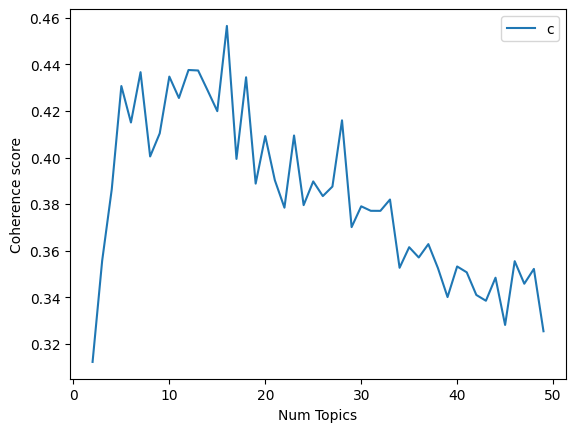

In [20]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3122
Num Topics = 3  has Coherence Value of 0.3557
Num Topics = 4  has Coherence Value of 0.3864
Num Topics = 5  has Coherence Value of 0.4307
Num Topics = 6  has Coherence Value of 0.4151
Num Topics = 7  has Coherence Value of 0.4367
Num Topics = 8  has Coherence Value of 0.4005
Num Topics = 9  has Coherence Value of 0.4104
Num Topics = 10  has Coherence Value of 0.4348
Num Topics = 11  has Coherence Value of 0.4256
Num Topics = 12  has Coherence Value of 0.4376
Num Topics = 13  has Coherence Value of 0.4374
Num Topics = 14  has Coherence Value of 0.4288
Num Topics = 15  has Coherence Value of 0.4199
Num Topics = 16  has Coherence Value of 0.4566
Num Topics = 17  has Coherence Value of 0.3994
Num Topics = 18  has Coherence Value of 0.4345
Num Topics = 19  has Coherence Value of 0.3888
Num Topics = 20  has Coherence Value of 0.4092
Num Topics = 21  has Coherence Value of 0.3903
Num Topics = 22  has Coherence Value of 0.3785
Num Topics = 23  has 

In [22]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.125*"coffee" + 0.027*"good" + 0.026*"cookie" + 0.026*"flavor" + 0.020*"strong" + 0.019*"taste" + 0.015*"bean" + 0.014*"great" + 0.013*"vanilla" + 0.013*"blend"'),
 (1,
  '0.077*"chocolate" + 0.031*"good" + 0.026*"bar" + 0.024*"green" + 0.024*"flavor" + 0.019*"milk" + 0.018*"tea" + 0.017*"dark" + 0.013*"taste" + 0.011*"variety"'),
 (2,
  '0.031*"bottle" + 0.029*"water" + 0.027*"drink" + 0.023*"bread" + 0.021*"energy" + 0.014*"great" + 0.013*"product" + 0.013*"oatmeal" + 0.011*"work" + 0.010*"breakfast"'),
 (3,
  '0.025*"good" + 0.025*"food" + 0.024*"treat" + 0.020*"great" + 0.020*"healthy" + 0.018*"snack" + 0.016*"dog" + 0.013*"cereal" + 0.012*"product" + 0.012*"ingredient"'),
 (4,
  '0.028*"good" + 0.020*"taste" + 0.019*"flavor" + 0.017*"sauce" + 0.016*"butter" + 0.015*"great" + 0.014*"peanut" + 0.013*"product" + 0.012*"coconut" + 0.011*"little"'),
 (5,
  '0.040*"price" + 0.040*"store" + 0.035*"amazon" + 0.028*"great" + 0.027*"good" + 0.019*"product" + 0.017*"local" + 0.016*"

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.100156  0.110091       1        1  15.416107
4     -0.061253 -0.073345       2        1  14.283750
7     -0.164577 -0.087154       3        1  13.929869
3      0.098190 -0.143807       4        1  13.143622
0     -0.178967  0.077808       5        1  12.181331
8      0.167349 -0.121618       6        1   9.983139
6      0.198180  0.205071       7        1   7.168797
1     -0.181820  0.111726       8        1   7.155088
2      0.022742 -0.078772       9        1   6.738297, topic_info=          Term          Freq         Total Category  logprob  loglift
1       coffee  30885.000000  30885.000000  Default  30.0000  30.0000
111       food  23437.000000  23437.000000  Default  29.0000  29.0000
133  chocolate  10967.000000  10967.000000  Default  28.0000  28.0000
78      flavor  32561.000000  32561.000000  Default  27.0000  27.0000
12     product  29042.000000  29042.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
91        time   1186.350941  17658.563081   Topic9  -4.7338  -0.0030
32        good   1309.720793  45580.898338   Topic9  -4.6348  -0.8523
15       stuff    830.346911   6238.315735   Topic9  -5.0906   0.6807
187     little    875.881807  14064.801277   Topic9  -5.0372  -0.0788
73       taste    867.191770  22746.830876   Topic9  -5.0471  -0.5696

[660 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2356       2  0.998086    addicted
14040      2  0.994595   addicting
5239       8  0.998984   addictive
2795       4  0.997950  additional
688        4  0.942572       adult
...      ...       ...         ...
19         9  0.029838        year
1859       7  0.997550       yeast
3735       8  0.004904      yogurt
3735       9  0.994234      yogurt
1020       4  0.996519        zuke

[1695 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 8, 4, 1, 9, 7, 2, 3])